<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_06_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.06 AutoEncoder

* 날짜: 2022-08-30, 31
* 이름: 박태현

## 학습내용
    - AutoEncoder를 이해하고 구현한다.
    - Denoising 을 적용해 본다. 
    - 이상치 탐지를 적용해 본다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os

In [3]:
sys.path.append('/content/drive/MyDrive/딥러닝 프레임워크실무/scripts')
from import_lib import *

## AutoEncoder 기본 구현
---

![](https://gaussian37.github.io/assets/img/dl/concept/autoencoder2/autoencoder.png)

### **| 모델 구성**

In [4]:
# 이미지 -> 이미지 norm : x/255 x 값이 0~1 사이 (0 or 1 이 아님)

# mnist = 28 * 28 = 784
def create_model(input_dims = 784):
  # encoder
  x = layers.Input(shape = input_dims)
  z = layers.Dense(128, activation = 'relu')(x)
  z = layers.Dense(64, activation = 'relu')(z)
  z = layers.Dense(16, activation = 'relu')(z)
  encoder = models.Model(x, z ,name = 'Encoder')

  # decoder
  y = layers.Dense(64, activation = 'relu')(z)
  y = layers.Dense(128, activation = 'relu')(y)
  y = layers.Dense(input_dims, activation = 'sigmoid')(y)
  decoder = models.Model(z, y, name = 'Decoder')

  z = encoder(x)
  y = decoder(z)
  model = models.Model(x,y, name = 'AutoEncoder')
  model.compile(loss = 'mse',
                optimizer = 'adam')
  model.summary()

  return encoder, decoder,model

In [5]:
encoder, decoder, model = create_model()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 Encoder (Functional)        (None, 16)                109776    
                                                                 
 Decoder (Functional)        (None, 784)               110544    
                                                                 
Total params: 220,320
Trainable params: 220,320
Non-trainable params: 0
_________________________________________________________________


### **| 학습**

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# norm
x_train = x_train/255.0
x_test = x_test/255.0
# flatten
x_train = x_train.reshape( (60000,-1) )
x_test = x_test.reshape( (10000, -1) )


x_train.shape, y_train.shape, x_test.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 784), (60000,), (10000, 784), (10000,))

In [7]:
history = model.fit( x_train, x_train, epochs = 50, batch_size = 128 )

Epoch 1/50
469/469 [==============================] - 4s 3ms/step - loss: 0.0506
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0261
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0216
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0196
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0184
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0176
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0170
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0165
Epoch 9/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0161
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0157
Epoch 11/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0153
Epoch 12/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0151
Epoch 13/50
469/469 [====

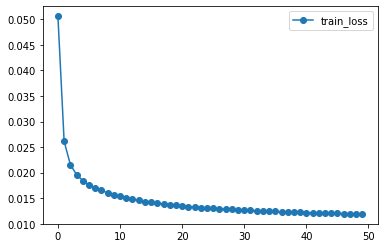

In [8]:
l = history.history['loss']
plt.plot(l, marker = 'o', label = 'train_loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [9]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 784), (10000, 784))

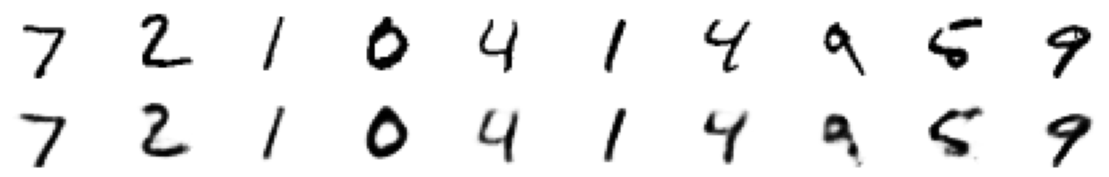

In [10]:
def display_res(org, rec):
  plt.figure(figsize = (20,3))

  for i in range(10) :
    plt.subplot(2,10,i+1)
    plt.imshow(org[i].reshape(28,28), cmap = 'gray_r')
    plt.axis('off')

    plt.subplot(2,10, i+11)
    plt.imshow(rec[i].reshape(28,28), cmap = 'gray_r')
    plt.axis('off')

  plt.show()

display_res(x_test,x_recon)

In [11]:
z = encoder(x_test[:1000])
z.shape

TensorShape([1000, 16])

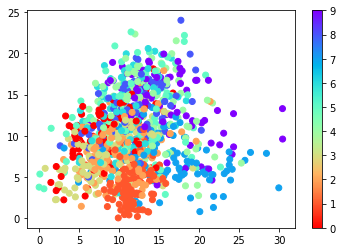

In [12]:
# 올바르게 됐다면 색, 라벨별로 모이는 경향이 있어야 한다.
plt.scatter(z[:,1], z[:,2], c = y_test[:1000], cmap = 'rainbow_r')
plt.colorbar()

## AutoEncoder 활용 - Denoising
---

### **| 데이터 준비**

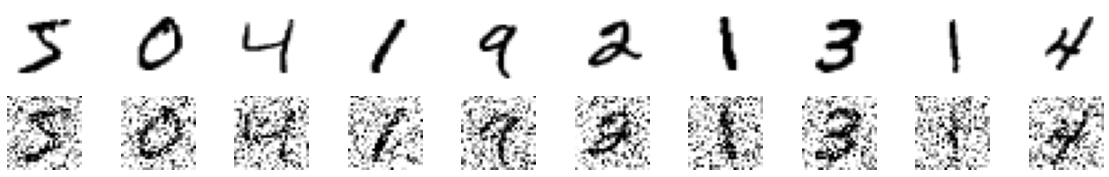

In [13]:
train_noise = np.random.normal(size=x_train.shape)
test_noise = np.random.normal(size=x_test.shape)

factor = 0.5

x_train_noisy = x_train + train_noise * factor
x_test_noisy = x_test + test_noise * factor

# 0-1 범위 벗어나지 않도록
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

display_res(x_train, x_train_noisy)

### **| 훈련**

In [14]:
history = model.fit(x_train_noisy, x_train, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0269
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0216
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0206
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0201
Epoch 5/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0197
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0194
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0192
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0190
Epoch 9/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0188
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 11/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0186
Epoch 12/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0185
Epoch 13/50
469/469 [====

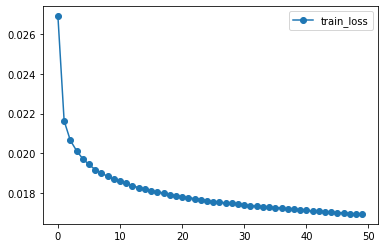

In [15]:
l = history.history['loss']
plt.plot(l, marker = 'o', label = 'train_loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [16]:
x_recon = model.predict(x_test_noisy)
x_recon.shape, x_test_noisy.shape

((10000, 784), (10000, 784))

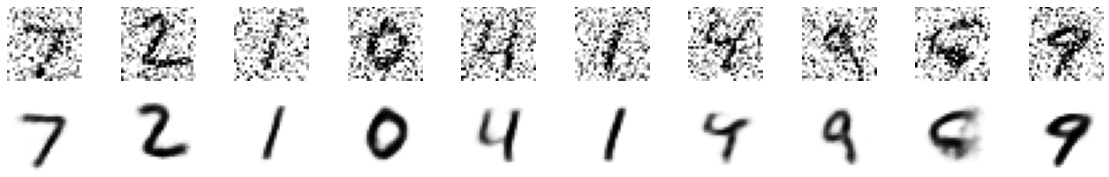

In [17]:
display_res(x_test_noisy, x_recon)

### CNN 활용

In [121]:
# 이미지 -> 이미지 norm : x/255 x 값이 0~1 사이 (0 or 1 이 아님)

# mnist = 28 * 28 = 784
def create_model_CNN(input_dims = (28,28,1)):
  # encoder
  x = layers.Input(shape = input_dims)
  z = layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu')(x)
  z = layers.MaxPooling2D((2,2), padding = 'same')(z)
  z = layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu')(z)
  z = layers.MaxPooling2D((2,2), padding = 'same')(z)

  encoder = models.Model(x, z ,name = 'Encoder')

  # decoder
  y = layers.Conv2DTranspose(32, (3,3), strides = 2, padding = 'same', activation = 'relu')(z)
  y = layers.Conv2DTranspose(32, (3,3), strides = 2,  padding = 'same', activation = 'relu')(y)
  y = layers.Conv2D(1, (3,3), padding = 'same', activation = 'sigmoid')(y)

  decoder = models.Model(z, y, name = 'Decoder')

  z = encoder(x)
  y = decoder(z)
  model = models.Model(x,y, name = 'AutoEncoder')
  model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam')
  model.summary()

  return encoder, decoder, model

In [122]:
encoder, decoder, model = create_model_CNN()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 7, 7, 32)          9568      
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         18785     
                                                                 
Total params: 28,353
Trainable params: 28,353
Non-trainable params: 0
_________________________________________________________________


In [123]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# norm
x_train = x_train/255.0
x_test = x_test/255.0
# flatten
# x_train = x_train.reshape( (60000,-1) )
# x_test = x_test.reshape( (10000, -1) )


x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [124]:
history = model.fit( x_train, x_train, epochs = 50, batch_size = 128 )

Epoch 1/50
469/469 [==============================] - 4s 6ms/step - loss: 0.1350
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0718
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0694
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0681
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0673
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0667
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0663
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0659
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0656
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0653
Epoch 11/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0651
Epoch 12/50
469/469 [==============================] - 3s 6ms/step - loss: 0.0648
Epoch 13/50
469/469 [====

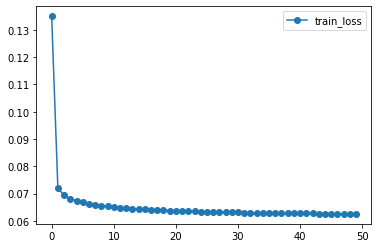

In [125]:
l = history.history['loss']
plt.plot(l, marker = 'o', label = 'train_loss')
plt.legend()
plt.show()

In [126]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 28, 28), (10000, 28, 28, 1))

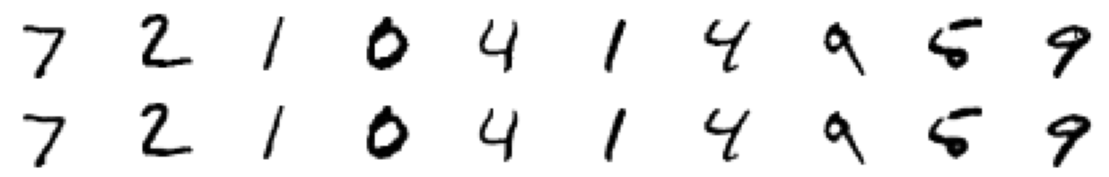

In [127]:
display_res(x_test,x_recon)

## AutoEncoder 활용 - 이상치 탐지
---

### **| 모델 구성**

In [92]:
def create_model2(Input_shape = (288,1)):

  def conv(x, filters, strides = 2, activation = 'relu'):
    y = layers.Conv1D(filters=filters,
                      kernel_size = 7,
                      padding = 'same',
                      strides = strides,
                      activation = activation)(x)
    return y

  def convT(x, filters, strides = 2, activation = 'relu'):
    y = layers.Conv1DTranspose(filters=filters,
                              kernel_size = 7,
                              padding = 'same',
                              strides = strides,
                              activation = activation)(x)
    return y

  # Encoder
  x = layers.Input(shape = Input_shape)
  y = conv(x, 32)
  y = layers.Dropout(.2)(y)
  y = conv(y, 8)

  # Decoder
  y = convT(y, 32)
  y = layers.Dropout(.2)(y)
  y = convT(y, 1, activation = None)

  model = models.Model(x,y)
  model.summary()

  model.compile(optimizer = 'adam', loss = 'mse')

  return model

create_model2()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 288, 1)]          0         
                                                                 
 conv1d_30 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_31 (Conv1D)          (None, 72, 8)             1800      
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 144, 32)          1824      
 Transpose)                                                      
                                                                 
 dropout_1 (Dropout)         (None, 144, 32)           0         
                                                           

### **| 데이터 준비**


In [35]:
# 데이터 : 시계열 데이터
# 데이터 하나의 shape : (288, 1)

data_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
train_path ="artificialNoAnomaly/art_daily_small_noise.csv"
test_path =  "artificialWithAnomaly/art_daily_jumpsup.csv"

In [37]:
df_train = pd.read_csv(data_url+train_path, parse_dates=True, index_col='timestamp')
df_test = pd.read_csv(data_url+test_path, parse_dates=True, index_col='timestamp')

print(df_train.shape, df_test.shape)

(4032, 1) (4032, 1)


In [38]:
df_train.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [51]:
# 정규화 - 평균 0, 표준편차 1
mean = df_train.mean()
std = df_train.std()

df_train_norm = (df_train - mean) / std
df_test_norm = (df_test - mean) / std

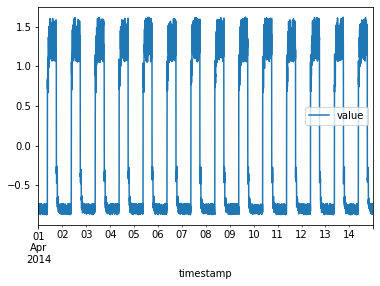

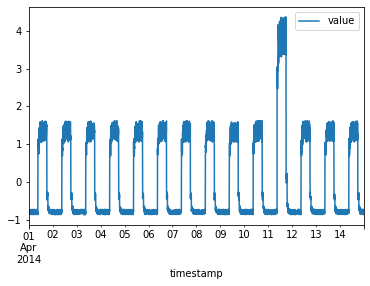

In [52]:
df_train_norm.plot()
df_test_norm.plot()

In [53]:
def create_seq(x, 
               window_size = 288,
               time_step = 1):
  y = []
  for i in range(len(x) - window_size + 1):
    if i % time_step == 0:
      seq = x[i: (i+window_size) ]
      y.append(seq)

  return np.array(y)

train = create_seq(df_train_norm)

print(train.shape, test.shape)

(3745, 288, 1) (3745, 288, 1)


In [83]:
test = create_seq(df_test_norm, time_step=288)
test.shape

(14, 288, 1)

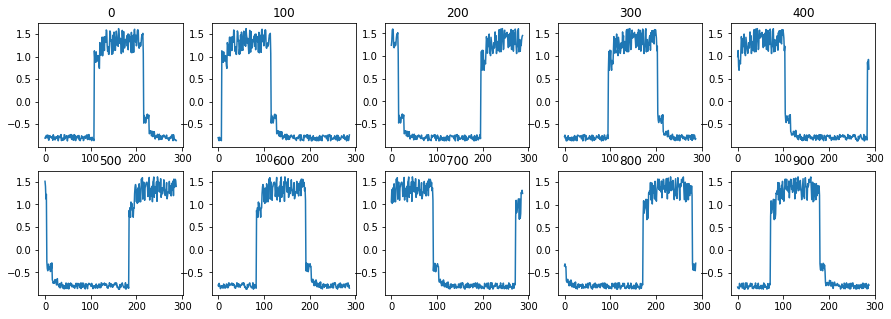

In [55]:
plt.figure(figsize = (15,5))
for i in range(10):
  idx = i*100
  plt.subplot(2,5,i+1)
  plt.title(idx)
  plt.plot(test[idx])

### **| 훈련**

In [93]:
model = create_model2()

history = model.fit(train, train, epochs = 30, batch_size=16)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 288, 1)]          0         
                                                                 
 conv1d_32 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_33 (Conv1D)          (None, 72, 8)             1800      
                                                                 
 conv1d_transpose_20 (Conv1D  (None, 144, 32)          1824      
 Transpose)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 144, 32)           0         
                                                           

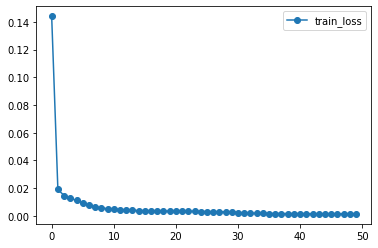

In [57]:
l = history.history['loss']
plt.plot(l, marker = 'o', label = 'train_loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [84]:
# 예측
train_pred = model.predict(train)
test_pred = model.predict(test)
train_pred.shape, train.shape

((3745, 288, 1), (3745, 288, 1))

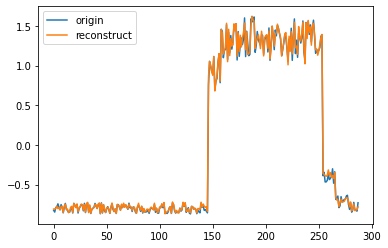

In [65]:
idx = 250
plt.plot(train[idx], label = 'origin')
plt.plot(train_pred[idx], label = 'reconstruct')
plt.legend()
plt.show()

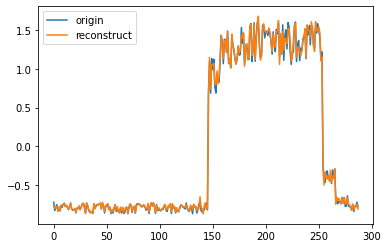

In [64]:
idx = 250
plt.plot(test[idx], label = 'origin')
plt.plot(test_pred[idx], label = 'reconstruct')
plt.legend()
plt.show()

첫 번째 테스트 샘플의 오차 : [0.02728497]


(array([ 519., 2605.,  227.,   13.,   56.,   69.,   65.,   44.,   85.,
          62.]),
 array([0.01627598, 0.02368495, 0.03109392, 0.03850288, 0.04591185,
        0.05332082, 0.06072978, 0.06813875, 0.07554772, 0.08295668,
        0.09036565]),
 <a list of 10 Patch objects>)

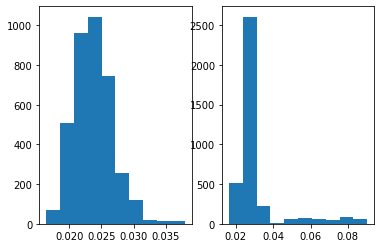

In [69]:
train_mae = np.mean(np.abs(train-train_pred), axis = 1)
test_mae = np.mean(np.abs(test-test_pred), axis = 1)
train_mae.shape, test_mae.shape
print(f'첫 번째 테스트 샘플의 오차 :', test_mae[120])
plt.subplot(1,2,1);plt.hist(train_mae)
plt.subplot(1,2,2);plt.hist(test_mae)


In [71]:
# 모델이 잘 재구현 하지 못 한 데이터 뽑아내기
이상치들 = np.where(test_mae>0.1)[0]

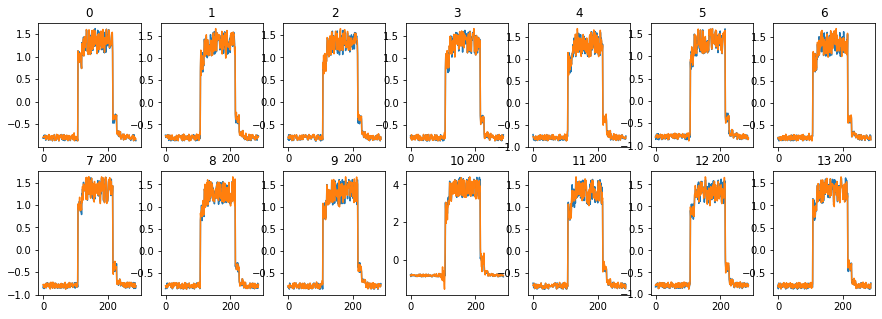

In [90]:
plt.figure(figsize = (15,5))
for i in range(14):
  plt.subplot(2,7,i+1)
  plt.title(i)
  plt.plot(test[i])
  plt.plot(test_pred[i])

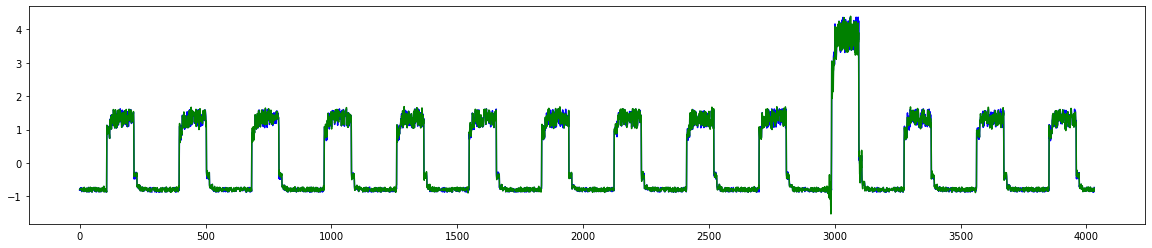

In [91]:
window_size = 288
plt.figure(figsize=(20,4))
for idx in range(len(test)):
  plt.plot(range(window_size*idx, window_size*(idx+1)),test[idx], c='b')
  l = test_mae[idx][0]
  if l>0.1:  
    print(f'샘플 [{idx}] 손실값: {test_mae[idx][0]:.2f}')
    plt.plot(range(window_size*idx, window_size*(idx+1)),test_pred[idx], c='r')
  else: 
    plt.plot(range(window_size*idx, window_size*(idx+1)),test_pred[idx], c='g')

plt.show()